In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [ ]:
env = gym.make("Taxi-v3")

state_space_size = env.observation_space.n
action_space_size = env.action_space.n

q_table = np.zeros((state_space_size, action_space_size))


In [ ]:
# Hyperparameters
alpha = 0.1         # Learning rate
gamma = 0.99        # Discount factor
epsilon = 1.0       # Exploration rate
epsilon_decay = 0.999
epsilon_min = 0.1
num_episodes = 10000


In [ ]:
for episode in range(num_episodes):
    state = env.reset()
    if isinstance(state, tuple):  # For Gymnasium compatibility
        state = state[0]

    done = False

    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result

        q_table[state][action] += alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
        )
        state = next_state

    epsilon = max(epsilon_min, epsilon * epsilon_decay)


In [ ]:
def decode_taxi_state(state):
    out = []
    out.append(state % 4)                # destination (0-3)
    state //= 4
    out.append(state % 5)                # passenger_location (0-4)
    state //= 5
    out.append(state % 5)                # taxi_col (0-4)
    state //= 5
    out.append(state)                    # taxi_row (0-4)
    return tuple(reversed(out))         # (taxi_row, taxi_col, passenger_loc, destination)




In [ ]:
def explain_action_from_state(state, action, q_table, reward=None, next_state=None):
    taxi_row, taxi_col, passenger_loc, destination = decode_taxi_state(state)
    q_val = q_table[state][action]

    # Convert action ID to direction
    action_names = {
        0: "South", 1: "North", 2: "East", 3: "West", 4: "Pickup", 5: "Dropoff"
    }
    action_str = action_names.get(action, str(action))

    # Identify event type (pickup, dropoff, moving)
    status = "→ Moving"
    if action == 4:
        status = "→ Attempting Pickup"
    elif action == 5:
        status = "→ Attempting Drop-off"
    if passenger_loc == 4:
        status = "Passenger Onboard"
    if next_state is not None:
        next_row, next_col, _, _ = decode_taxi_state(next_state)
        if (next_row, next_col) == locs[destination] and action == 5:
            status = "Dropped Passenger"

    reward_info = f" | Reward: {reward}" if reward is not None else ""
    return (f"Taxi at ({taxi_row},{taxi_col}) | Passenger: {passenger_loc} → {destination} | "
            f"Action: {action} ({action_str}) | Q-value: {q_val:.2f}{reward_info} | {status}")


In [ ]:
locs = [(0,0), (0,4), (4,0), (4,3)]  # R, G, Y, B
labels = ['R', 'G', 'Y', 'B']
colors = ['red', 'green', 'yellow', 'blue']

num_visualizations = 5
rewards_all = []


In [ ]:
traffic_grid = np.zeros((5, 5))
np.random.seed(42)
for _ in range(6):
    r, c = np.random.randint(0, 5, size=2)
    traffic_grid[r][c] = np.random.uniform(0.5, 1.0)


In [ ]:
weather_grid = np.zeros((5, 5))
for _ in range(5):
  r, c = np.random.randint(0, 5, size=2)
  weather_grid[r][c] = np.random.uniform(0.3, 1.0)  # intensity from mild to harsh


Taxi at (1,3) | Passenger: 1 → 2 | Action: 1 (North) | Q-value: 7.44 | Reward: -1 | → Moving
Energy: 99.0 (Cost this step: 1.00)
Taxi at (0,3) | Passenger: 1 → 2 | Action: 2 (East) | Q-value: 8.53 | Reward: -1 | → Moving
Energy: 98.0 (Cost this step: 1.00)
Taxi at (0,4) | Passenger: 1 → 2 | Action: 4 (Pickup) | Q-value: 9.62 | Reward: -1 | → Attempting Pickup
Energy: 97.0 (Cost this step: 1.00)
Taxi at (0,4) | Passenger: 4 → 2 | Action: 3 (West) | Q-value: 10.73 | Reward: -1 | Passenger Onboard
Energy: 96.0 (Cost this step: 1.00)
Taxi at (0,3) | Passenger: 4 → 2 | Action: 3 (West) | Q-value: 11.85 | Reward: -1 | Passenger Onboard
Energy: 95.0 (Cost this step: 1.00)
Taxi at (0,2) | Passenger: 4 → 2 | Action: 0 (South) | Q-value: 12.98 | Reward: -1 | Passenger Onboard
Energy: 94.0 (Cost this step: 1.00)
Taxi at (1,2) | Passenger: 4 → 2 | Action: 0 (South) | Q-value: 14.12 | Reward: -1 | Passenger Onboard
Traffic penalty at (2,2): -1.46
Weather penalty at (2,2): -0.87
Energy: 91.7 (Cost t

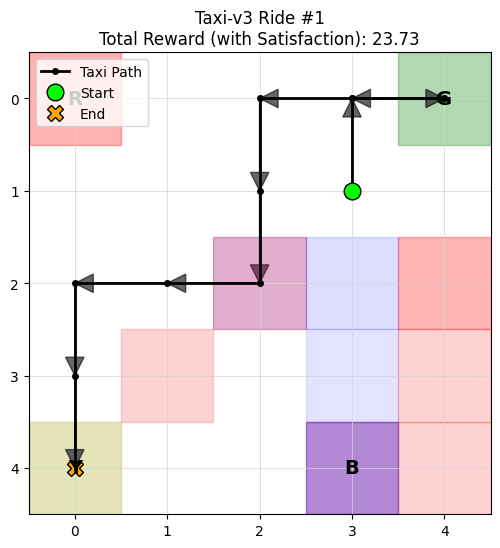

Taxi at (3,0) | Passenger: 3 → 0 | Action: 1 (North) | Q-value: 4.10 | Reward: -1 | → Moving
Energy: 99.0 (Cost this step: 1.00)
Taxi at (2,0) | Passenger: 3 → 0 | Action: 2 (East) | Q-value: 5.30 | Reward: -1 | → Moving
Energy: 98.0 (Cost this step: 1.00)
Taxi at (2,1) | Passenger: 3 → 0 | Action: 2 (East) | Q-value: 6.37 | Reward: -1 | → Moving
Traffic penalty at (2,2): -1.46
Weather penalty at (2,2): -0.87
Energy: 95.7 (Cost this step: 2.31)
Taxi at (2,2) | Passenger: 3 → 0 | Action: 2 (East) | Q-value: 7.44 | Reward: -1 | → Moving
Weather penalty at (2,3): -0.99
Energy: 94.0 (Cost this step: 1.66)
Taxi at (2,3) | Passenger: 3 → 0 | Action: 0 (South) | Q-value: 8.53 | Reward: -1 | → Moving
Weather penalty at (3,3): -0.83
Energy: 92.5 (Cost this step: 1.56)
Taxi at (3,3) | Passenger: 3 → 0 | Action: 0 (South) | Q-value: 9.62 | Reward: -1 | → Moving
Traffic penalty at (4,3): -1.14
Weather penalty at (4,3): -0.47
Energy: 90.6 (Cost this step: 1.89)
Taxi at (4,3) | Passenger: 3 → 0 | Ac

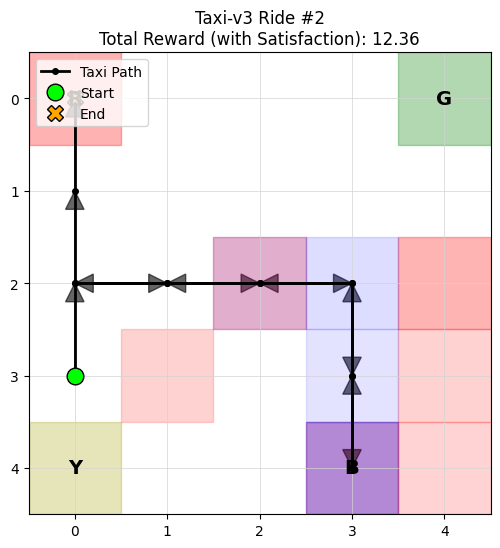

Taxi at (2,1) | Passenger: 3 → 0 | Action: 2 (East) | Q-value: 6.37 | Reward: -1 | → Moving
Traffic penalty at (2,2): -1.46
Weather penalty at (2,2): -0.87
Energy: 97.7 (Cost this step: 2.31)
Taxi at (2,2) | Passenger: 3 → 0 | Action: 2 (East) | Q-value: 7.44 | Reward: -1 | → Moving
Weather penalty at (2,3): -0.99
Energy: 96.0 (Cost this step: 1.66)
Taxi at (2,3) | Passenger: 3 → 0 | Action: 0 (South) | Q-value: 8.53 | Reward: -1 | → Moving
Weather penalty at (3,3): -0.83
Energy: 94.5 (Cost this step: 1.56)
Taxi at (3,3) | Passenger: 3 → 0 | Action: 0 (South) | Q-value: 9.62 | Reward: -1 | → Moving
Traffic penalty at (4,3): -1.14
Weather penalty at (4,3): -0.47
Energy: 92.6 (Cost this step: 1.89)
Taxi at (4,3) | Passenger: 3 → 0 | Action: 4 (Pickup) | Q-value: 10.73 | Reward: -1 | → Attempting Pickup
Traffic penalty at (4,3): -1.14
Weather penalty at (4,3): -0.47
Energy: 90.7 (Cost this step: 1.89)
Taxi at (4,3) | Passenger: 4 → 0 | Action: 1 (North) | Q-value: 11.85 | Reward: -1 | Pas

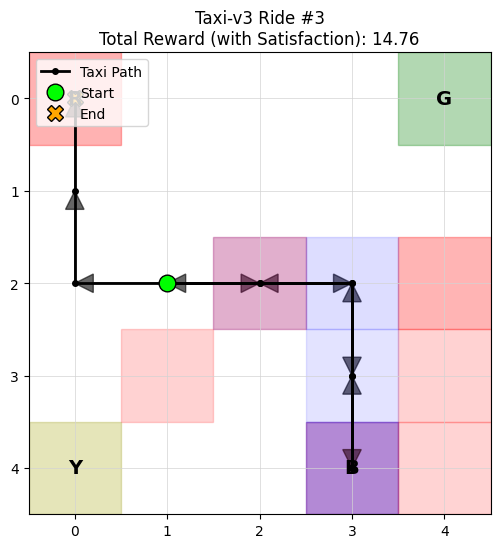

Taxi at (4,4) | Passenger: 0 → 3 | Action: 1 (North) | Q-value: -0.41 | Reward: -1 | → Moving
Traffic penalty at (3,4): -1.18
Energy: 98.4 (Cost this step: 1.59)
Taxi at (3,4) | Passenger: 0 → 3 | Action: 1 (North) | Q-value: 3.11 | Reward: -1 | → Moving
Traffic penalty at (2,4): -1.97
Energy: 96.4 (Cost this step: 1.98)
Taxi at (2,4) | Passenger: 0 → 3 | Action: 3 (West) | Q-value: 4.25 | Reward: -1 | → Moving
Weather penalty at (2,3): -0.99
Energy: 94.8 (Cost this step: 1.66)
Taxi at (2,3) | Passenger: 0 → 3 | Action: 3 (West) | Q-value: 5.30 | Reward: -1 | → Moving
Traffic penalty at (2,2): -1.46
Weather penalty at (2,2): -0.87
Energy: 92.5 (Cost this step: 2.31)
Taxi at (2,2) | Passenger: 0 → 3 | Action: 3 (West) | Q-value: 6.37 | Reward: -1 | → Moving
Energy: 91.5 (Cost this step: 1.00)
Taxi at (2,1) | Passenger: 0 → 3 | Action: 1 (North) | Q-value: 7.44 | Reward: -1 | → Moving
Energy: 90.5 (Cost this step: 1.00)
Taxi at (1,1) | Passenger: 0 → 3 | Action: 3 (West) | Q-value: 8.53 

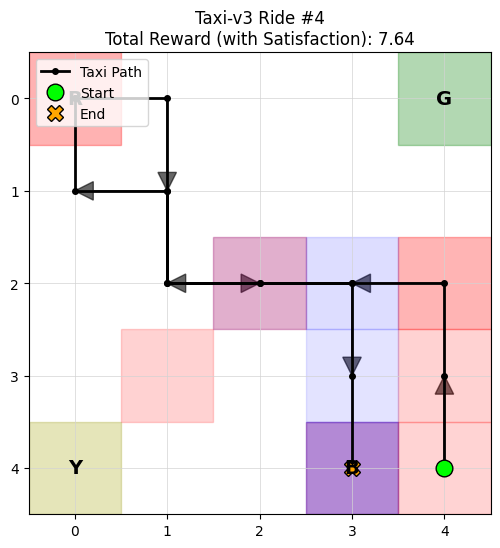

Taxi at (2,2) | Passenger: 1 → 0 | Action: 1 (North) | Q-value: 5.30 | Reward: -1 | → Moving
Energy: 99.0 (Cost this step: 1.00)
Taxi at (1,2) | Passenger: 1 → 0 | Action: 2 (East) | Q-value: 6.37 | Reward: -1 | → Moving
Energy: 98.0 (Cost this step: 1.00)
Taxi at (1,3) | Passenger: 1 → 0 | Action: 1 (North) | Q-value: 7.44 | Reward: -1 | → Moving
Energy: 97.0 (Cost this step: 1.00)
Taxi at (0,3) | Passenger: 1 → 0 | Action: 2 (East) | Q-value: 8.53 | Reward: -1 | → Moving
Energy: 96.0 (Cost this step: 1.00)
Taxi at (0,4) | Passenger: 1 → 0 | Action: 4 (Pickup) | Q-value: 9.62 | Reward: -1 | → Attempting Pickup
Energy: 95.0 (Cost this step: 1.00)
Taxi at (0,4) | Passenger: 4 → 0 | Action: 3 (West) | Q-value: 10.73 | Reward: -1 | Passenger Onboard
Energy: 94.0 (Cost this step: 1.00)
Taxi at (0,3) | Passenger: 4 → 0 | Action: 0 (South) | Q-value: 11.85 | Reward: -1 | Passenger Onboard
Energy: 93.0 (Cost this step: 1.00)
Taxi at (1,3) | Passenger: 4 → 0 | Action: 0 (South) | Q-value: 12.9

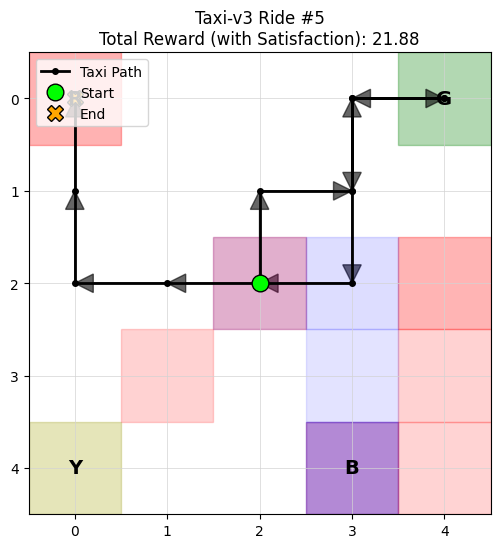

In [ ]:
for ride in range(num_visualizations):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    steps = 0
    max_steps_per_episode = 200

    taxi_positions = []
    pickup_location = None
    dropoff_location = None
    total_reward = 0

    # User Satisfaction Trackers
    pickup_time = None
    dropoff_time = None

    energy = 100  # Max energy


    while not done and steps < max_steps_per_episode:
        taxi_row, taxi_col, passenger_loc, destination = decode_taxi_state(state)
        taxi_positions.append((taxi_row, taxi_col))

        if pickup_location is None and passenger_loc < 4:
            pickup_location = locs[passenger_loc]
        if 0 <= destination < 4:
            dropoff_location = locs[destination]

        action = np.argmax(q_table[state])
        step_result = env.step(action)

        if len(step_result) == 5:
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_result

        # Enhanced explainability print
        print(explain_action_from_state(state, action, q_table, reward=reward, next_state=next_state))


        # Track pickup and dropoff steps
        if pickup_time is None and passenger_loc == 4:
            pickup_time = steps

        if pickup_time is not None and dropoff_time is None and passenger_loc == 4:
            drop_row, drop_col, _, dest = decode_taxi_state(state)
            if (drop_row, drop_col) == locs[dest] and action == 5:
                dropoff_time = steps

        total_reward += reward

        next_row, next_col, _, _ = decode_taxi_state(next_state)
        traffic_penalty = traffic_grid[next_row][next_col]
        if traffic_penalty > 0:
            penalty = traffic_penalty * 2  # scale as needed
            total_reward -= penalty
            print(f"Traffic penalty at ({next_row},{next_col}): -{penalty:.2f}")


        weather_penalty = weather_grid[next_row][next_col]
        if weather_penalty > 0:
            w_penalty = weather_penalty * 1.5  # scale factor for weather
            total_reward -= w_penalty
            print(f"Weather penalty at ({next_row},{next_col}): -{w_penalty:.2f}")


                # Compute energy cost
        base_cost = 1
        traffic_load = traffic_grid[next_row][next_col]
        weather_load = weather_grid[next_row][next_col]
        move_cost = base_cost + traffic_load + weather_load

        energy -= move_cost
        print(f"Energy: {energy:.1f} (Cost this step: {move_cost:.2f})")

        # Apply heavy penalty if energy depleted
        if energy <= 0:
            print("Energy depleted!")
            total_reward -= 20  # harsh penalty
            done = True



        state = next_state
        steps += 1

    # Add user satisfaction bonus
    satisfaction_bonus = 0
    if pickup_time is not None and dropoff_time is not None:
        wait_penalty = pickup_time * 0.2
        ride_penalty = (dropoff_time - pickup_time) * 0.1
        satisfaction_bonus = 20 - (wait_penalty + ride_penalty)
        total_reward += satisfaction_bonus
        print(f"Satisfaction bonus: {satisfaction_bonus:.2f} (Wait: {pickup_time}, Ride: {dropoff_time - pickup_time})")

    print(f"Final reward (with satisfaction): {total_reward:.2f}")
    rewards_all.append(total_reward)

    # --- Visualization ---
    plt.figure(figsize=(6,6))
    grid = np.ones((5, 5, 3)) * 0.95  # light gray

    # Draw pickup/dropoff locations
    for idx, (row, col) in enumerate(locs):
        plt.gca().add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, fill=True, color=colors[idx], alpha=0.3))
        plt.text(col, row, labels[idx], fontsize=14, ha='center', va='center', weight='bold')

    # Plot taxi trajectory
    pos_rows, pos_cols = zip(*taxi_positions)
    plt.plot(pos_cols, pos_rows, 'k.-', label='Taxi Path', linewidth=2, markersize=8)

    # Mark start and end
    plt.plot(pos_cols[0], pos_rows[0], 'o', color='lime', label='Start', markersize=12, markeredgecolor='k')
    plt.plot(pos_cols[-1], pos_rows[-1], 'X', color='orange', label='End', markersize=12, markeredgecolor='k')

    # Draw arrows
    N = max(1, len(pos_rows)//8)
    for i in range(0, len(pos_rows)-1, N):
        plt.arrow(pos_cols[i], pos_rows[i], pos_cols[i+1]-pos_cols[i], pos_rows[i+1]-pos_rows[i],
                  head_width=0.2, head_length=0.2, fc='black', ec='black', alpha=0.6, length_includes_head=True)

    plt.xlim(-0.5, 4.5)
    plt.ylim(4.5, -0.5)
    plt.gca().set_aspect('equal')
    plt.grid(True, which='both', color='lightgray', linewidth=0.5)
    plt.xticks(range(5))
    plt.yticks(range(5))
    plt.title(f"Taxi-v3 Ride #{ride+1}\nTotal Reward (with Satisfaction): {total_reward:.2f}")
    plt.legend(loc='upper left')
        # Draw traffic zones
    for r in range(5):
        for c in range(5):
            if traffic_grid[r][c] > 0:
                plt.gca().add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, fill=True, color='red', alpha=traffic_grid[r][c]*0.3))

        # Draw weather zones
    for r in range(5):
        for c in range(5):
            if weather_grid[r][c] > 0:
                plt.gca().add_patch(
                    plt.Rectangle((c-0.5, r-0.5), 1, 1, fill=True, color='blue', alpha=weather_grid[r][c]*0.2))



    plt.show()


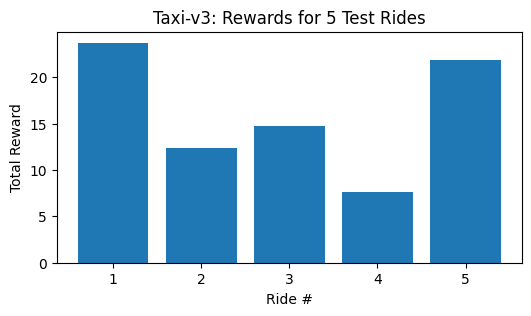

In [ ]:
plt.figure(figsize=(6,3))
plt.bar(range(1, num_visualizations+1), rewards_all[:num_visualizations])
plt.xlabel("Ride #")
plt.ylabel("Total Reward")
plt.title(f"Taxi-v3: Rewards for {num_visualizations} Test Rides")
plt.show()